In [1]:
from IPython.display import clear_output
import numpy as np
from framework.io_functions import Reader, Writer
from framework.pre_processing import PreProcessor
from framework.dfts import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.ofunction import OFunction
from framework.utilities import real_to_complex, complex_to_real, find_pixel
from framework.priors import TSV, TV, L1, Chi2
from framework.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.analytical_functions import Gaussian
from scipy.constants import c
from scipy import signal as sci_signal
from pandas.plotting import autocorrelation_plot
import itertools

In [2]:
def make_scenario1(phi_gal, l2, l2_ref, p0=1.0):
    
    alpha = 0.7
    nu0 = 1.4e9
    nu = c/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*phi_gal*(l2-l2_ref))
    mu_u = p0*k*np.sin(2.*phi_gal*(l2-l2_ref))
    
    p = np.mean(np.sqrt(mu_q**2+mu_u**2))
    
    return mu_q, mu_u

In [3]:
def apply_noise(P, noise=1.0):
    q_noise = np.random.normal(loc=0.0, scale=noise, size=len(P))
    u_noise = np.random.normal(loc=0.0, scale=noise, size=len(P))
    p_noise = q_noise + 1j * u_noise
    
    P_noisy = P + p_noise
    return P_noisy

In [4]:
nu_min = 0.58e9  # minimum frequency
nu_max = 2.50e9  # maximum frequency
l2_min = (c/nu_max)**2
l2_max = (c/nu_min)**2

nu = np.linspace(nu_min, nu_max, 512)  # make data regularly spaced in frequency
#t1 = np.linspace(l2_min, l2_max, 512) # make data regularly spaced in lambda^2

#nu = c/np.sqrt(t1)
t1 = c/nu
t1 = t1[::-1]

In [5]:
pre_proc = PreProcessor(freqs=nu)

#W, K = pre_proc.calculate_W_K(sigma=sigma)
W, K = pre_proc.calculate_W_K()
l2, l2_ref, phi, phi_r = pre_proc.calculate_phi(W, K, times=8, verbose=True)
n = len(phi)
m = len(l2)

Minimum Lambda-squared: 0.014 m^2
Maximum Lambda-squared: 0.267 m^2
delta Lambda-squared min: 4.332e-05 m^2
delta Lambda-squared max: 0.003 m^2
delta Lambda-squared mean: 4.947e-04 m^2
FWHM of the main peak of the RMTF: 13.704 rad/m^2
Maximum recovered width structure: 218.468 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 3501.259


In [6]:
phi_gal = 50.
stokesQ, stokesU = make_scenario1(phi_gal, l2, l2_ref, p0=1.0)
P = stokesQ + 1j * stokesU

# Apply noise to the data
P_noisy = apply_noise(P, noise=0.5)
#P = P_noisy

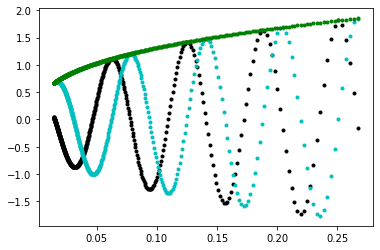

In [7]:
plt.plot(l2, P.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P), 'g.', label=r"$|P|$")

In [8]:
nufft = NUFFT1D(W=W, lambda2=l2, lambda2_ref=l2_ref, phi=phi)

In [9]:
dft = DFT1D(W=W, lambda2=l2, lambda2_ref=l2_ref, phi=phi)

In [10]:
F_dirty = dft.backward(P)

(-500.0, 500.0)

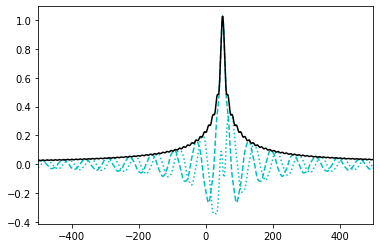

In [11]:
plt.plot(phi, F_dirty.real, 'c--', label=r"Real part")
plt.plot(phi, F_dirty.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_dirty), 'k-', label=r"Amplitude")
plt.xlim([-500,500])

In [12]:
idx_noise = np.where(np.abs(phi)>3000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F

0.016579008

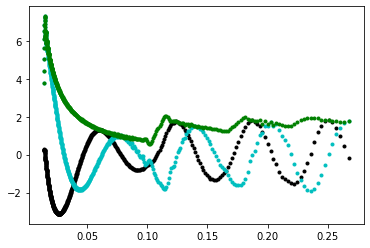

In [13]:
test_P = dft.forward_normalized(F_dirty)
plt.plot(l2, test_P.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, test_P.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(test_P), 'g.', label=r"$|P|$")

In [14]:
P_back = nufft.forward_normalized(F_dirty)

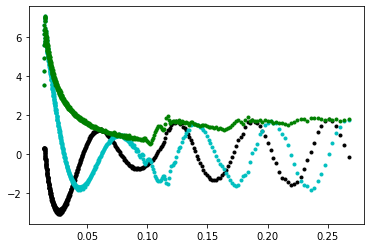

In [15]:
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")

In [16]:
F_back = nufft.backward(P)

4064

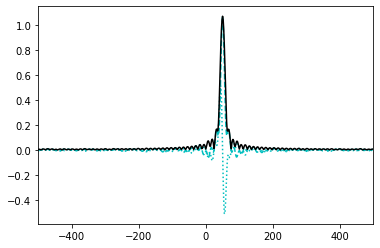

In [17]:
plt.plot(phi, F_back.real, 'c--', label=r"Real part")
plt.plot(phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-500,500])
len(F_back)

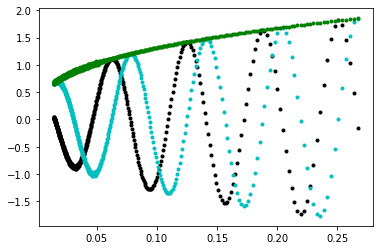

In [18]:
P_back = nufft.forward_normalized(F_back)
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")

In [52]:
lambda_l1 = np.sqrt(2 * len(P) + 4 * np.sqrt(len(P)))*noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(b=P, dft_obj=nufft, w=W)
tsv = TSV(reg=lambda_tsv)
l1 = L1(reg=lambda_l1)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

F_real = complex_to_real(F_back)

In [53]:
opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()
X = real_to_complex(X)

Iterations set to 33
Iteration:  0  objective function value: 177.03186


(-200.0, 200.0)

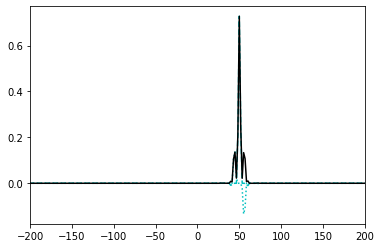

In [54]:
X_recon = X*K/n
plt.plot(phi, X_recon.real, 'c--', label=r"Real part")
plt.plot(phi, X_recon.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(X_recon), 'k-', label=r"Amplitude")
plt.xlim([-200,200])

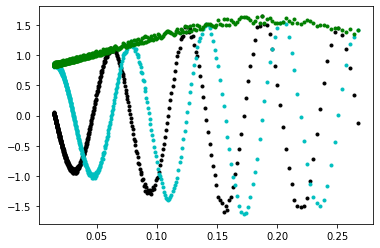

In [55]:
P_back = nufft.forward_normalized(X)
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")

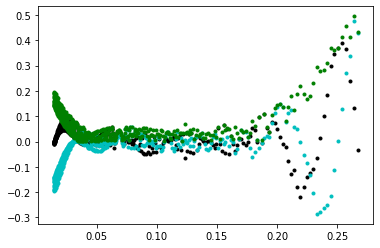

In [56]:
residual = P - P_back
plt.plot(l2, residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(residual), 'g.', label=r"$|P|$")

(-500.0, 500.0)

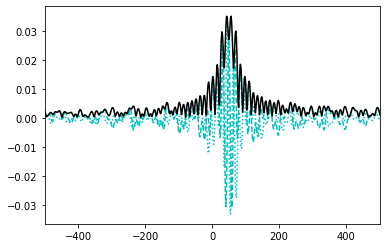

In [57]:
F_residual = nufft.backward(residual)
plt.plot(phi, F_residual.real, 'c--', label=r"Real part")
plt.plot(phi, F_residual.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_residual), 'k-', label=r"Amplitude")
plt.xlim([-500,500])

In [58]:
F_spike = np.zeros_like(F_back)
idx = np.argmax(np.abs(F_back))
F_spike[idx] = 1.0 + 0.0j

(-200.0, 200.0)

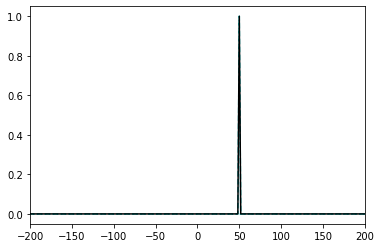

In [59]:
plt.plot(phi, F_spike.real, 'c--', label=r"Real part")
plt.plot(phi, F_spike.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_spike), 'k-', label=r"Amplitude")
plt.xlim([-200,200])

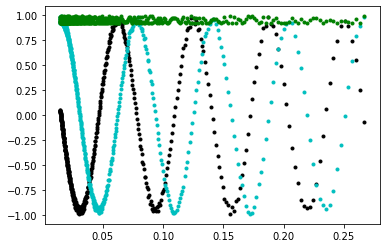

In [60]:
P_spike = nufft.forward(F_spike)
plt.plot(l2, P_spike.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_spike.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_spike), 'g.', label=r"$|P|$")